In [1]:
import os

os.getcwd()

'/mnt/e/WSL/AI/CNN'

In [11]:
import torch
import numpy as np
import utils
import data
import train
import preprocess

In [4]:
## Merged version
from torchbearer.cv_utils import DatasetValidationSplitter
import CNN_transformer_model as cnntrans

pos_fasta_list = ['mature_leaf_H3K4me3.fa', 'root_H3K4me3.fa', 'panicle_H3K4me3.fa','young_leaf_H3K4me3.fa']
neg_fasta_file = './training_data/H3K4me3_flank_negative.fa'
seq_len = 1000

neg_seqs = [ seq for seq in utils.load_data(neg_fasta_file) if len(seq) == seq_len ]

metrics_plot = dict()

pre_fasta = './prediction/H3K4me3_for_prediction.fa'
pre_seqs, pre_ids = utils.load_data(pre_fasta, label=True)
filter_ind = [ i for i, seqs in enumerate(pre_seqs) if len(seqs) == seq_len ]
pre_seqs = [ pre_seqs[i] for i in filter_ind ]
pre_ids = [ pre_ids[i] for i in filter_ind ]

nuc_predict = preprocess.NucPreprocess(pre_seqs)
X_predict = nuc_predict.onehot_for_nuc()

predict_dataset = data.NucDataset(x=X_predict, y=[0]*len(X_predict))
predict_batch_size = 300
threshold = 0.9

predict_loader = torch.utils.data.DataLoader(dataset=predict_dataset, batch_size=predict_batch_size, shuffle=False, num_workers=0)

for pos_fasta in pos_fasta_list:
    pos_fasta_file = './training_data/{}'.format(pos_fasta)
    pos_seqs = [ seq for seq in utils.load_data(pos_fasta_file) if len(seq) == seq_len ]
    
    seqs = pos_seqs + neg_seqs
    labels = [1]*len(pos_seqs) + [0]*len(neg_seqs)
    print('Start {}, pos num:{}, neg num:{}'.format(pos_fasta, len(pos_seqs), len(neg_seqs)))
    
    nuc_pre = preprocess.NucPreprocess(seqs)
    X_all = nuc_pre.onehot_for_nuc()

    # Random choosing
    np.random.seed(seed=20230831)

    testing_rate = 0.1
    testing_index = np.random.choice(np.arange(len(X_all)), size=int(len(X_all)*testing_rate), replace=False)
    training_index = [ i for i in range(len(X_all)) if i not in testing_index ]

    X_training = [ X_all[i] for i in training_index ]
    y_training = np.array([ labels[i] for i in training_index ])

    X_testing = [ X_all[i] for i in testing_index ]
    y_testing = np.array([ labels[i] for i in testing_index ])
    
    dataset = data.NucDataset(x=X_training, y=y_training)

    validition_rate = 0.2

    data_splitter = DatasetValidationSplitter(len(dataset), validition_rate)
    train_set = data_splitter.get_train_dataset(dataset)
    val_set = data_splitter.get_val_dataset(dataset)

    # Define batch size parameter
    batch_size=64

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True, num_workers=0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cpu = torch.device('cpu')

    epoch = 50
    lr = 1e-5

    # seq_len = 200
    # feature_size = 2

    # cnn_nums = 20

    # model = explain.ExplaiNN(num_cnns=cnn_nums, input_length=seq_len, num_classes=feature_size)
    # model = model.to(device)

    cnn_kernel_size=17
    cnn_nfilter=80
    cnn_maxpooling_size=41
    cnn_dropout=0.1
    tf_features=24 #(seq_len-cnn_kernel_size+1)//cnn_maxpooling_size
    tf_nhead=3
    tf_dropout=0.3
    tf_nlayer= 6
    dense_dropout=0.2

    model = cnntrans.ATAC_CNN_Transformer(seq_len, cnn_kernel_size, cnn_nfilter, cnn_maxpooling_size, cnn_dropout, tf_features, tf_nhead, tf_dropout, tf_nlayer, dense_dropout)
    model = model.to(device)
    
    record_pattern = 'cnntrans_cks17_cn80_cms41_cd1_tnh2_td3_tn6_dd2_seq1000_{}'.format(pos_fasta)

    model_dir = './model/{}.model'.format(record_pattern)
    
    train.training_classifier(batch_size=batch_size, n_epoch=epoch, lr=lr, model_dir=model_dir, 
                             train=train_loader, valid=val_loader, model=model, device=device)
    
    test_dataset = data.NucDataset(x=X_testing, y=y_testing)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model = torch.load(model_dir).to(device)
    model.eval()

    total_correct = 0
    total_labels = torch.tensor([0],dtype=torch.float)
    total_outputs = torch.tensor([0],dtype=torch.float)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device, dtype=torch.float)
            outputs = model(inputs)
            if outputs.shape[0] > 1:
                outputs = outputs.squeeze()
            else:
                outputs = outputs.squeeze()
                outputs = outputs.reshape(1)
                labels = labels.reshape(1)

            total_outputs = torch.concat((total_outputs, outputs.to(torch.device('cpu'),dtype=torch.float)))
            total_labels = torch.concat((total_labels, labels))
            labels = labels.to(device, dtype=torch.float)
            correct = utils.evaluation(outputs, labels)
            total_correct += correct        


    trans_final_correct = total_correct/len(test_dataset)
    print('Testing correct of {}: {:.2f}%'.format(pos_fasta, trans_final_correct*100))

    # ROC metric
    trans_fpr, trans_tpr, trans_au_roc = utils.get_metrics(total_outputs, total_labels, metric='ROC')
    trans_roc_plot = utils.draw_metrics(trans_fpr, trans_tpr, trans_au_roc, metric='ROC')

    # PR metric
    trans_recall, trans_precision, trans_aver_precision = utils.get_metrics(total_outputs, total_labels, metric='PR')
    trans_pr_plot = utils.draw_metrics(trans_recall, trans_precision, trans_aver_precision, metric='PR')
    
    metrics_plot[pos_fasta] = {'ROC': trans_roc_plot, 'PR': trans_pr_plot}
    
    

    model = torch.load(model_dir).to(device)
    model.eval()

    possible_seqs_ind = list()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(predict_loader):
            inputs = inputs.to(device, dtype=torch.float)
            outputs = model(inputs)
            possible_seqs_ind += (torch.where(outputs.squeeze()>threshold)[0].to(cpu).numpy() + i*predict_batch_size).tolist()
            
            
    from tqdm import tqdm
    start = 0
    end = 1000
    step = 3
    length = 17
    min_threshold = 0.2

    model = torch.load(model_dir).to(device)
    model.eval()

    pos_result = list()

    with torch.no_grad():
        for ind in tqdm(possible_seqs_ind):
            possible_seqs = X_predict[ind].clone()
            tmp_seqlist = list()
            for i in range(start, end, step):
                if i+length <= end:
                    tmp_tensor = possible_seqs.clone() 
                    tmp_tensor[i:i+length] = torch.zeros(4*length).reshape(length,4)
                    tmp_seqlist.append(tmp_tensor)
            pos_predict = model(torch.vstack(tmp_seqlist).reshape(len(tmp_seqlist), seq_len, 4).to(device, dtype=torch.float)).squeeze()
            if pos_predict.min() <= min_threshold:
                pos_start = pos_predict.argmin()*step
                pos_end = pos_start + length
                pos_seqs = pre_seqs[ind][pos_start:pos_end]
                tmp_result = {'id': pre_ids[ind],'whole_seq': pre_seqs[ind],
                              'start': int(pos_start.to(cpu)), 'end': int(pos_end.to(cpu)), 
                              'possible_seqs': pos_seqs, 'pre_value': ','.join(map(str,pos_predict.to(cpu).tolist())),
                              'min_value': float(pos_predict.min().to(cpu)),
                              'param_step': step, 'param_len': length}
                pos_result.append(tmp_result)
                
    import seaborn as sns
    import pandas as pd

    pre_df = pd.DataFrame(pos_result)
    pre_df.to_csv('./prediction/Possible_sites_predict_{}.csv'.format(pos_fasta))
    
    new_coor = list()
    for i,pos in enumerate(pre_df['id'].to_numpy().tolist()):
        start = pre_df['start'].to_numpy().tolist()[i]
        new_pos = pos.split(':')[0]+":"+str(int(pos.split(':')[1].split('-')[0])+start)+"-"+pos.split(':')[1].split('-')[1]
        new_coor.append(new_pos)
    
    with open('./prediction/new_coor_predict_{}.txt'.format(pos_fasta),'w') as f:
        for rec in new_coor:
            f.write(rec+'\n')

Start mature_leaf_H3K4me3.fa, pos num:13544, neg num:31709

Start training, parameters total: 1011961, trainable: 1011961

[ Epoch1: 510/510 ] loss:0.407 
Train | Loss:0.51865
Valid | Loss:0.43976 
saving model with loss 56.289
-----------------------------------------------
[ Epoch2: 510/510 ] loss:0.547 
Train | Loss:0.32465
Valid | Loss:0.48476 
-----------------------------------------------
[ Epoch3: 510/510 ] loss:0.281 
Train | Loss:0.27561
Valid | Loss:0.48084 
-----------------------------------------------
[ Epoch4: 510/510 ] loss:0.102 
Train | Loss:0.26032
Valid | Loss:0.48728 
-----------------------------------------------
[ Epoch5: 510/510 ] loss:0.258 
Train | Loss:0.25267
Valid | Loss:0.47434 
-----------------------------------------------
[ Epoch6: 510/510 ] loss:0.203 
Train | Loss:0.24694
Valid | Loss:0.43118 
saving model with loss 55.192
-----------------------------------------------
[ Epoch7: 510/510 ] loss:0.125 
Train | Loss:0.24248
Valid | Loss:0.39261 
savi

100%|███████████████████████████████████████████████████████████████████████████████| 2030/2030 [00:45<00:00, 44.42it/s]


Start root_H3K4me3.fa, pos num:15855, neg num:31709

Start training, parameters total: 1011961, trainable: 1011961

[ Epoch1: 536/536 ] loss:0.244 
Train | Loss:0.54210
Valid | Loss:0.33614 
saving model with loss 45.043
-----------------------------------------------
[ Epoch2: 536/536 ] loss:0.302 
Train | Loss:0.33453
Valid | Loss:0.36622 
-----------------------------------------------
[ Epoch3: 536/536 ] loss:0.105 
Train | Loss:0.29495
Valid | Loss:0.30004 
saving model with loss 40.206
-----------------------------------------------
[ Epoch4: 536/536 ] loss:0.147 
Train | Loss:0.27340
Valid | Loss:0.31401 
-----------------------------------------------
[ Epoch5: 536/536 ] loss:0.098 
Train | Loss:0.26145
Valid | Loss:0.31946 
-----------------------------------------------
[ Epoch6: 536/536 ] loss:0.170 
Train | Loss:0.25719
Valid | Loss:0.34501 
-----------------------------------------------
[ Epoch7: 536/536 ] loss:0.047 
Train | Loss:0.25092
Valid | Loss:0.31649 
-----------

100%|███████████████████████████████████████████████████████████████████████████████| 1786/1786 [00:41<00:00, 42.88it/s]


Start panicle_H3K4me3.fa, pos num:12764, neg num:31709

Start training, parameters total: 1011961, trainable: 1011961

[ Epoch1: 501/501 ] loss:0.275 
Train | Loss:0.51914
Valid | Loss:0.34276 
saving model with loss 43.188
-----------------------------------------------
[ Epoch2: 501/501 ] loss:0.283 
Train | Loss:0.33746
Valid | Loss:0.30438 
saving model with loss 38.352
-----------------------------------------------
[ Epoch3: 501/501 ] loss:0.221 
Train | Loss:0.28953
Valid | Loss:0.29102 
saving model with loss 36.668
-----------------------------------------------
[ Epoch4: 501/501 ] loss:0.267 
Train | Loss:0.27616
Valid | Loss:0.32253 
-----------------------------------------------
[ Epoch5: 501/501 ] loss:0.269 
Train | Loss:0.26896
Valid | Loss:0.31505 
-----------------------------------------------
[ Epoch6: 501/501 ] loss:0.232 
Train | Loss:0.26320
Valid | Loss:0.34178 
-----------------------------------------------
[ Epoch7: 501/501 ] loss:0.140 
Train | Loss:0.25837


100%|███████████████████████████████████████████████████████████████████████████████| 2058/2058 [00:47<00:00, 42.95it/s]


Start young_leaf_H3K4me3.fa, pos num:14041, neg num:31709

Start training, parameters total: 1011961, trainable: 1011961

[ Epoch1: 515/515 ] loss:0.310 
Train | Loss:0.51209
Valid | Loss:0.33419 
saving model with loss 43.111
-----------------------------------------------
[ Epoch2: 515/515 ] loss:0.354 
Train | Loss:0.30266
Valid | Loss:0.32226 
saving model with loss 41.572
-----------------------------------------------
[ Epoch3: 515/515 ] loss:0.275 
Train | Loss:0.26321
Valid | Loss:0.33095 
-----------------------------------------------
[ Epoch4: 515/515 ] loss:0.362 
Train | Loss:0.25151
Valid | Loss:0.33501 
-----------------------------------------------
[ Epoch5: 515/515 ] loss:0.356 
Train | Loss:0.24817
Valid | Loss:0.35562 
-----------------------------------------------
[ Epoch6: 515/515 ] loss:0.261 
Train | Loss:0.24388
Valid | Loss:0.29888 
saving model with loss 38.555
-----------------------------------------------
[ Epoch7: 515/515 ] loss:0.189 
Train | Loss:0.238

100%|█████████████████████████████████████████████████████████████████████████████████| 828/828 [00:19<00:00, 41.93it/s]


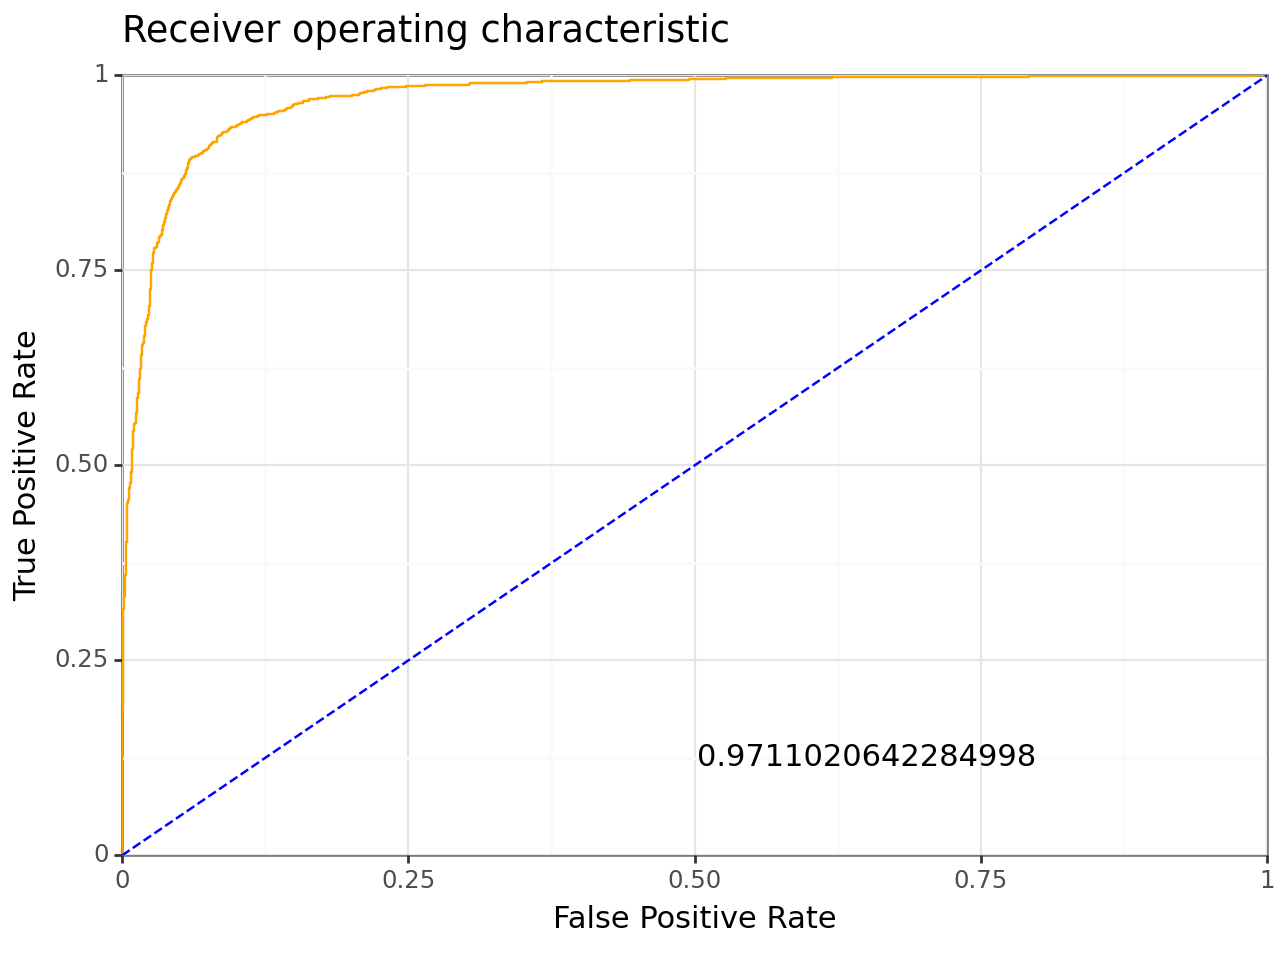

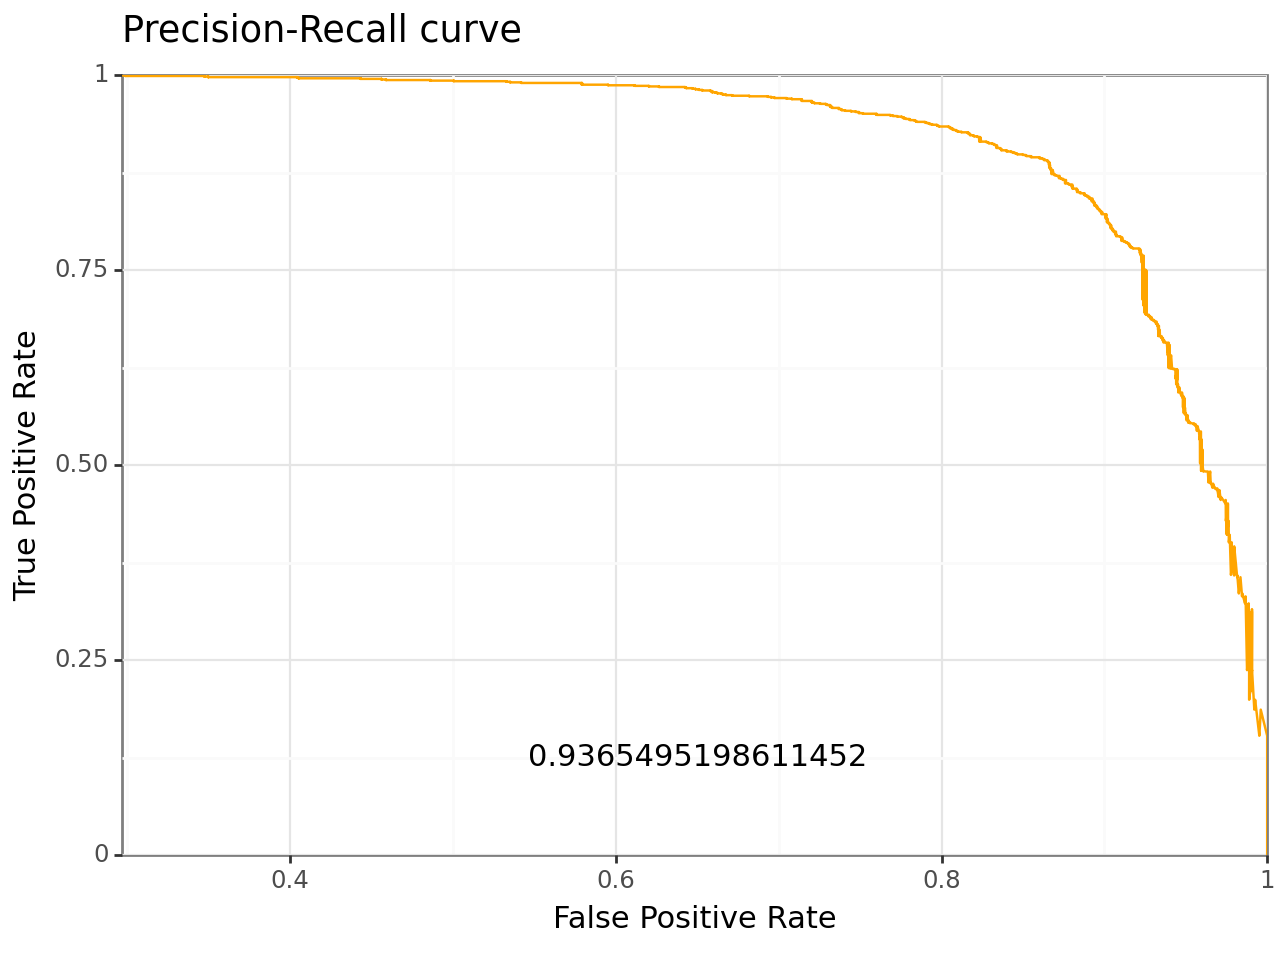

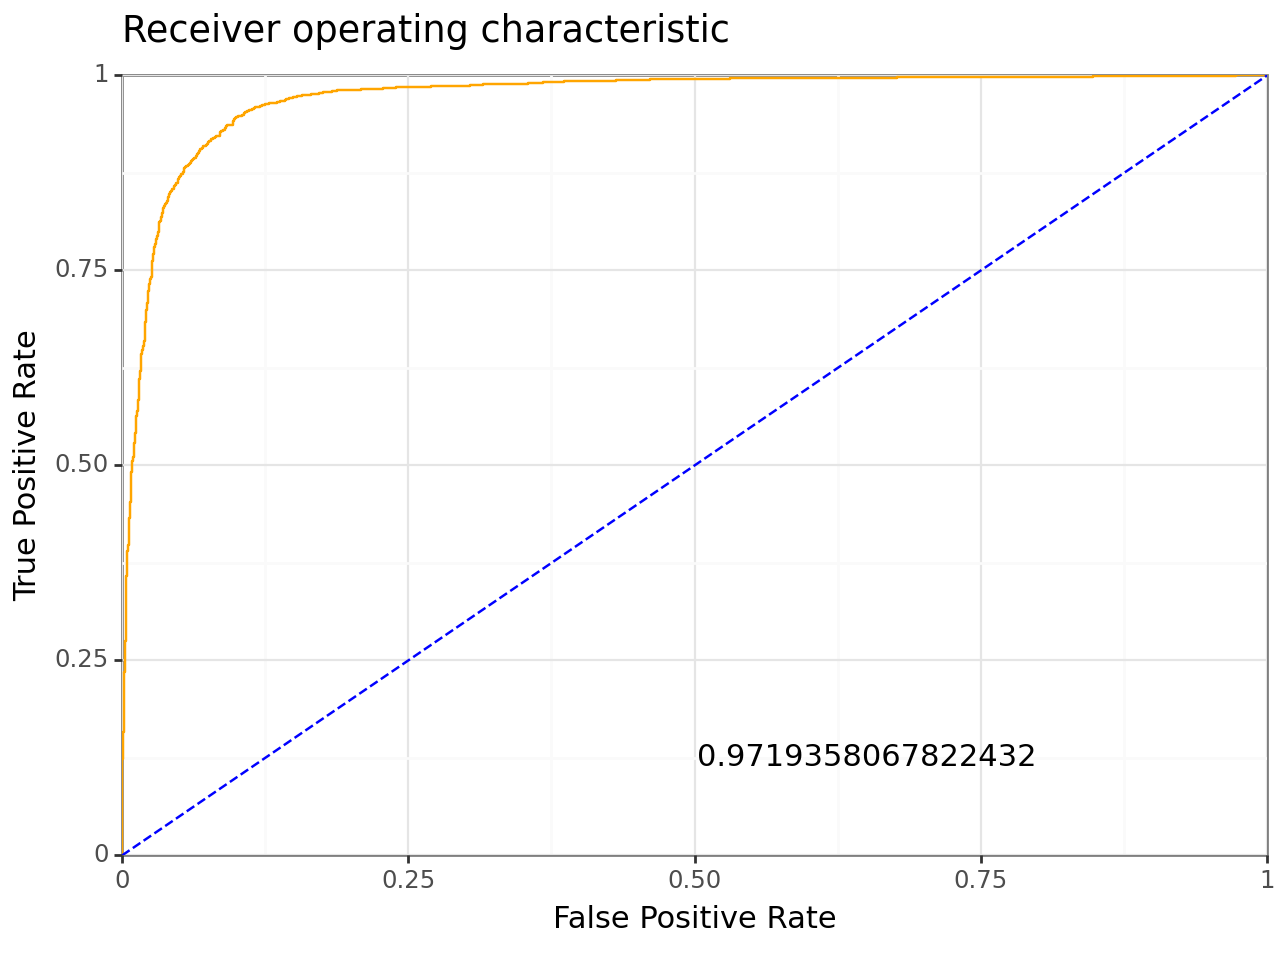

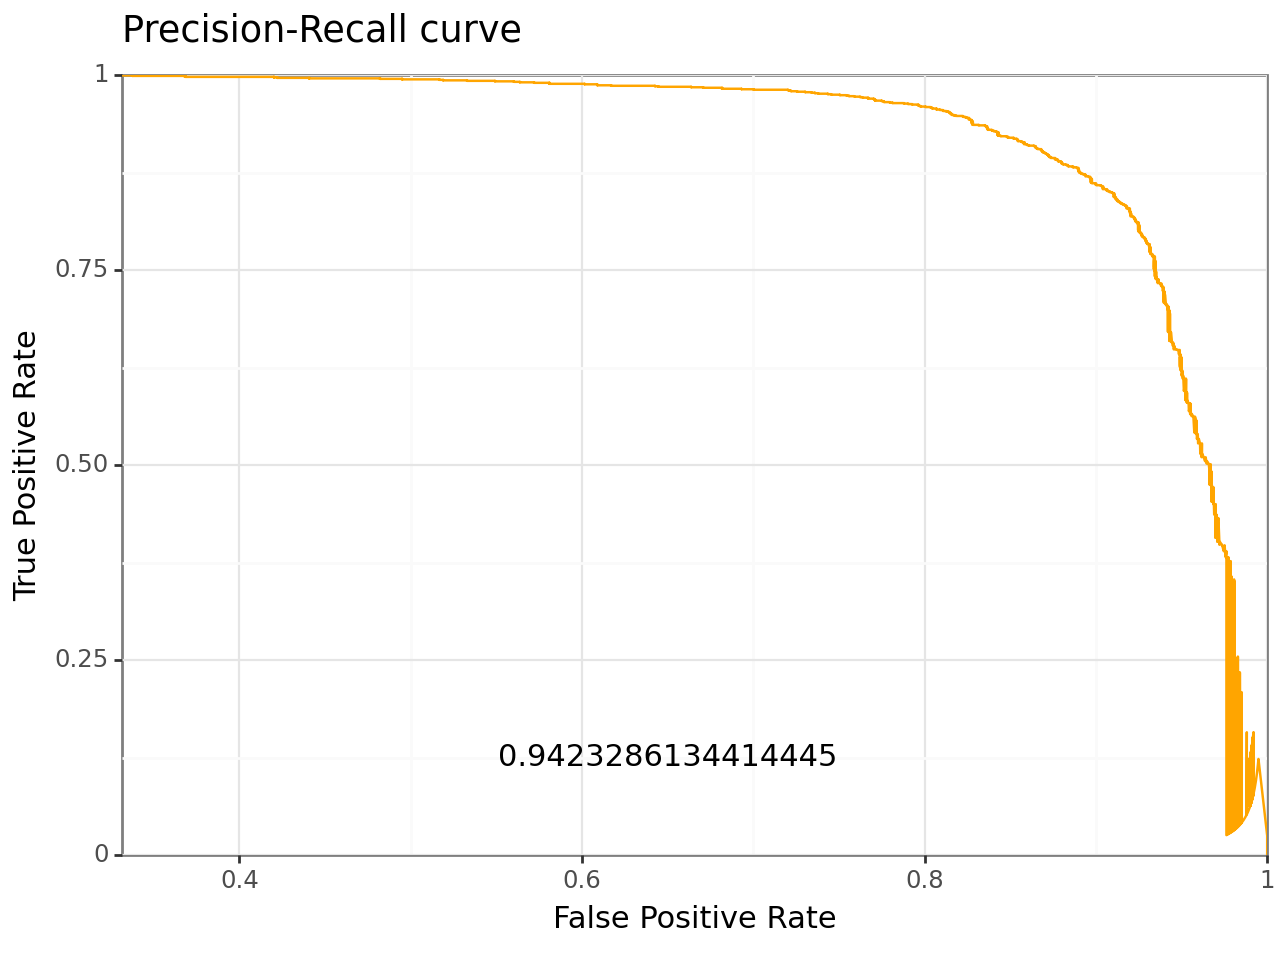

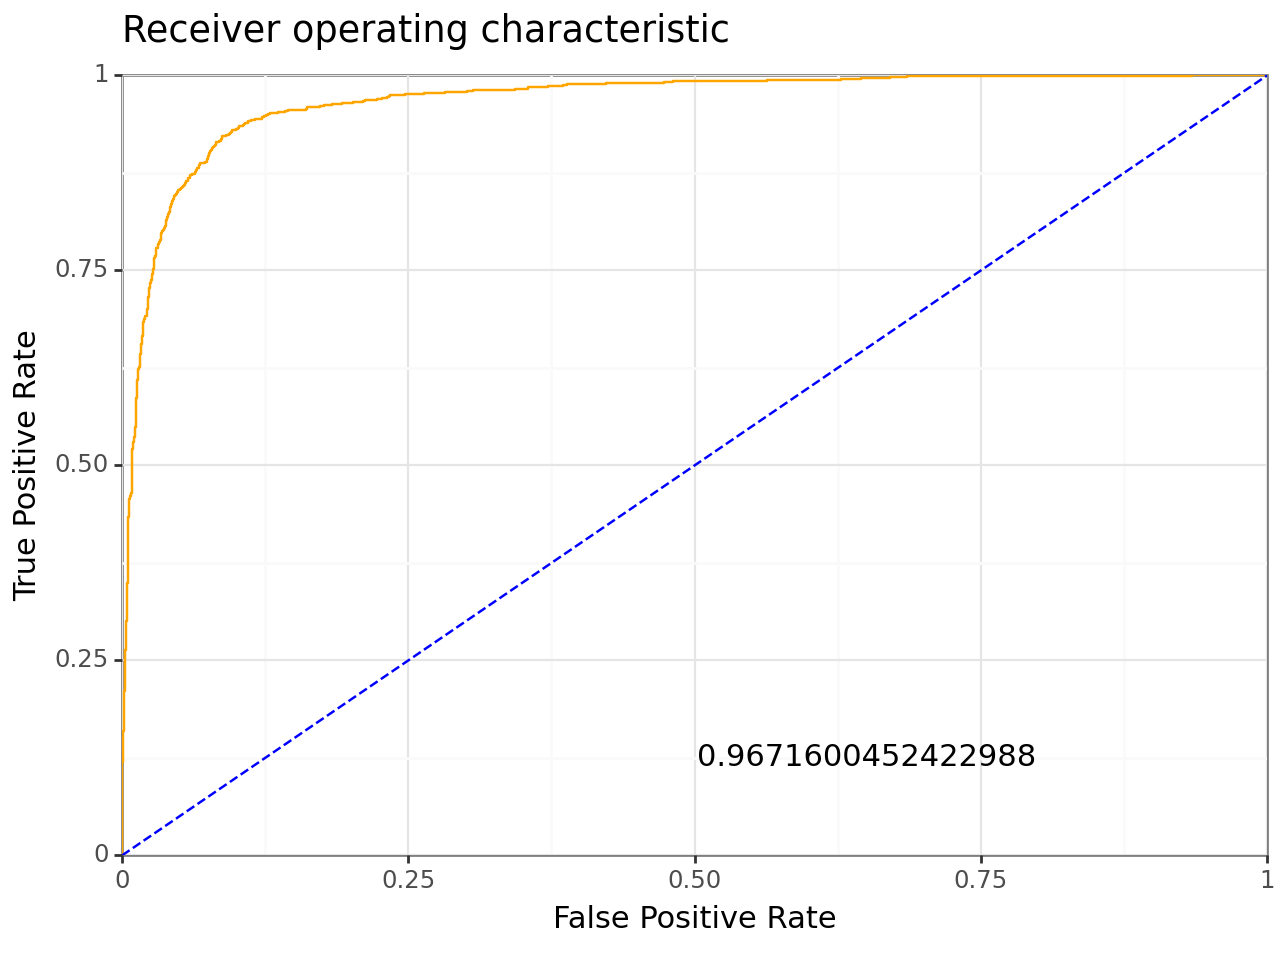

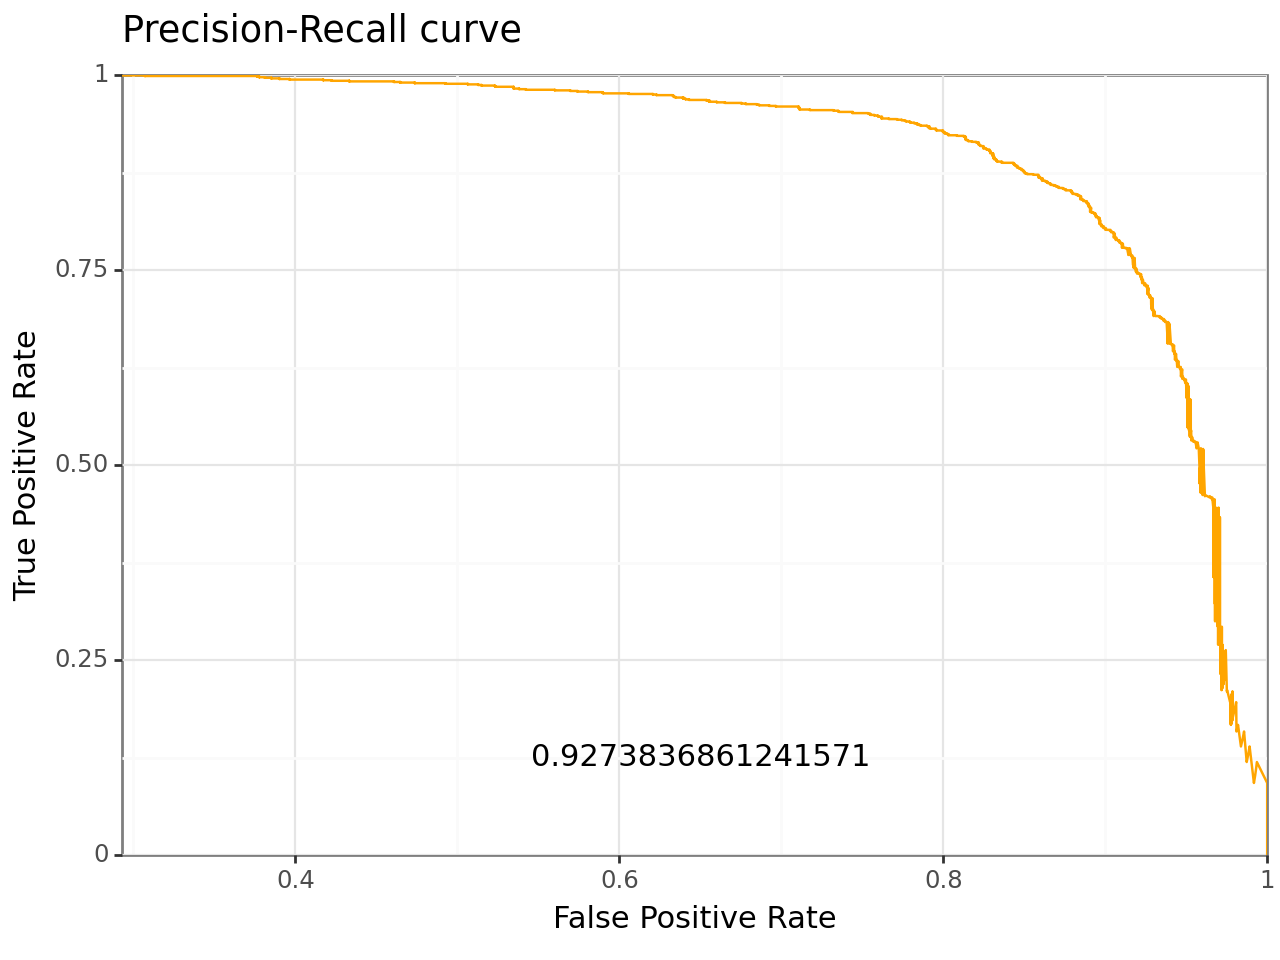

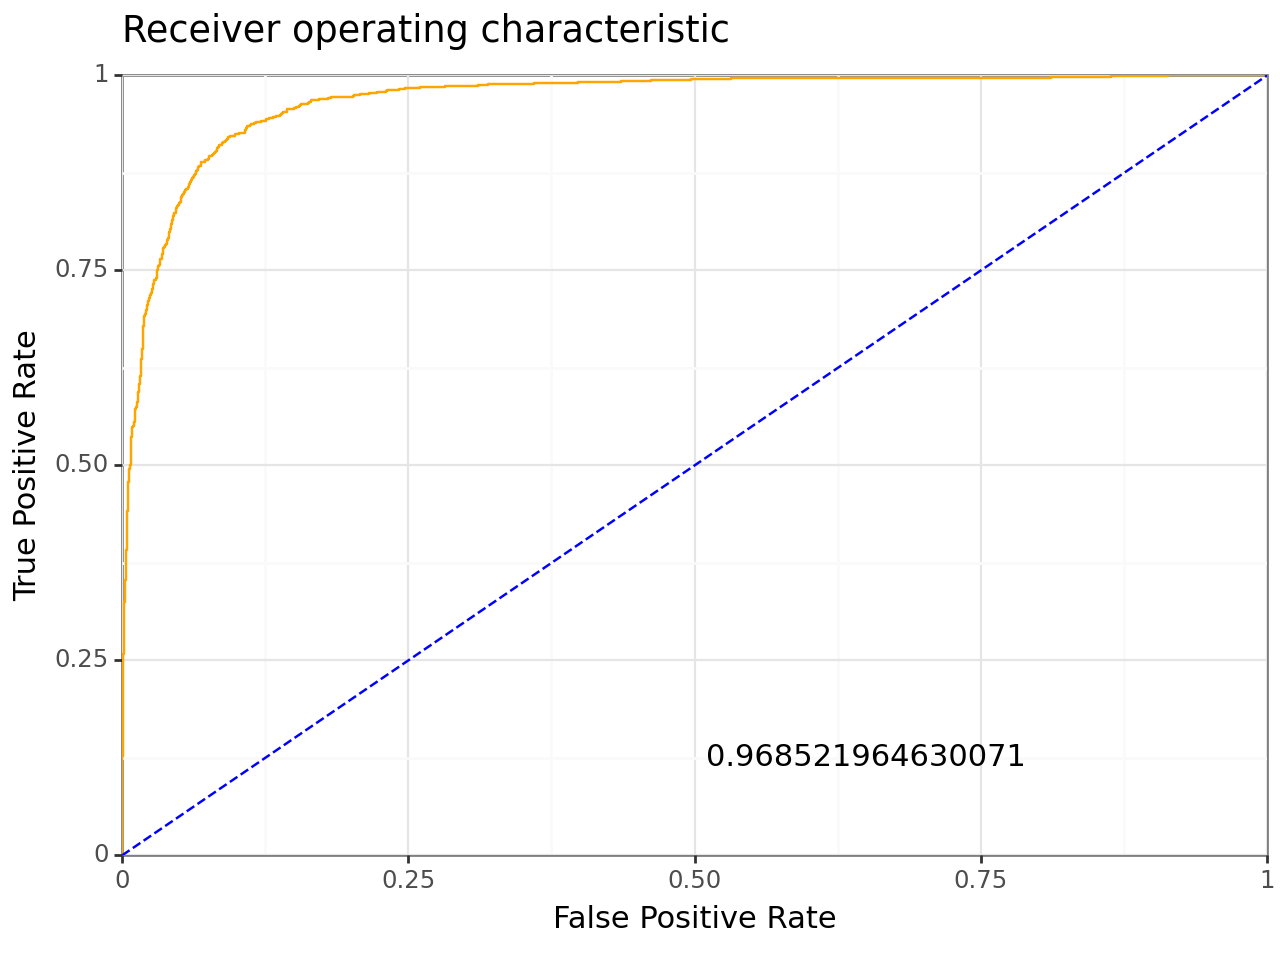

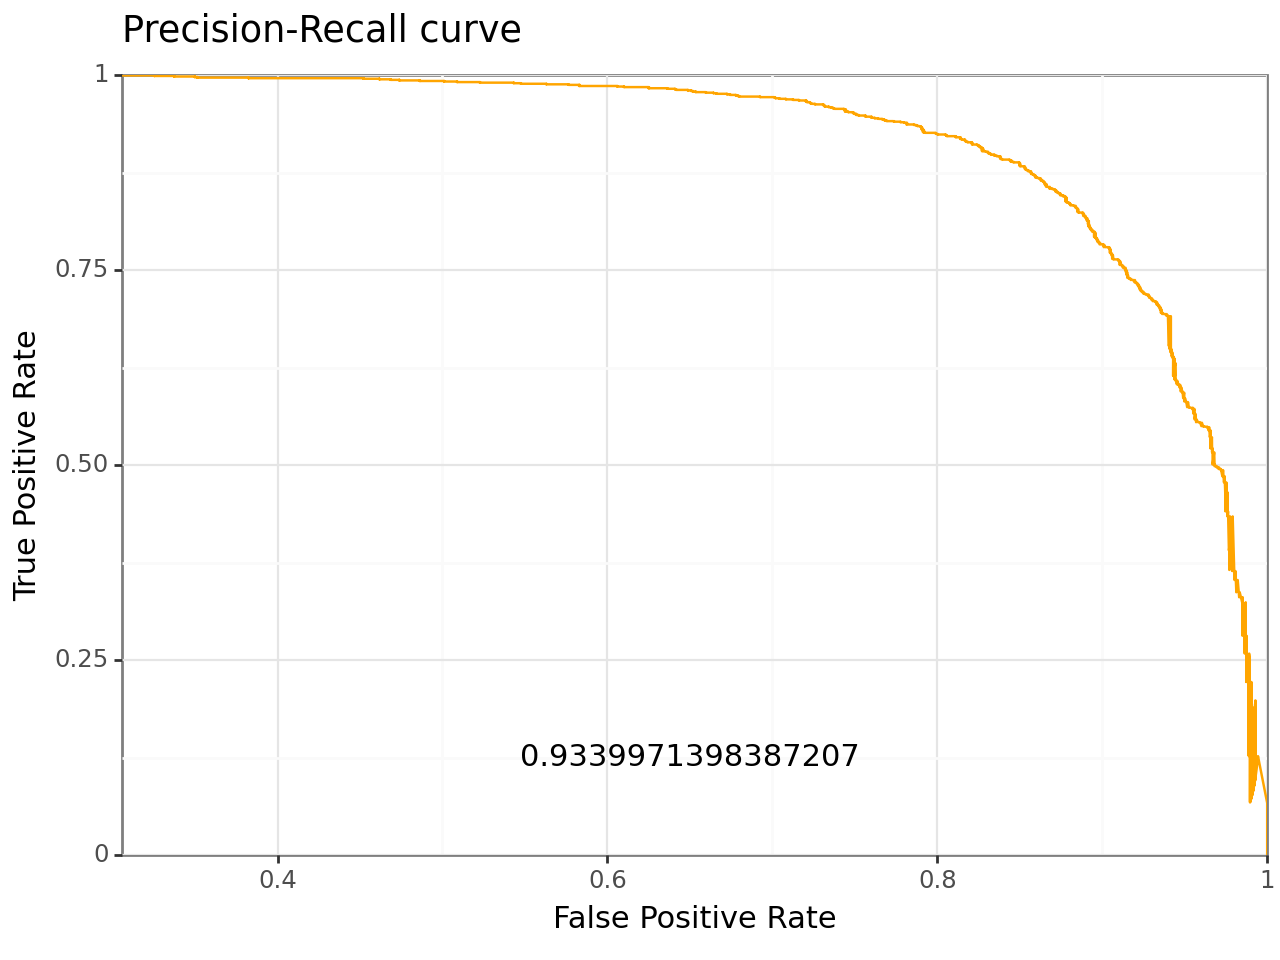

{'mature_leaf_H3K4me3.fa': {'ROC': <Figure Size: (640 x 480)>,
  'PR': <Figure Size: (640 x 480)>},
 'root_H3K4me3.fa': {'ROC': <Figure Size: (640 x 480)>,
  'PR': <Figure Size: (640 x 480)>},
 'panicle_H3K4me3.fa': {'ROC': <Figure Size: (640 x 480)>,
  'PR': <Figure Size: (640 x 480)>},
 'young_leaf_H3K4me3.fa': {'ROC': <Figure Size: (640 x 480)>,
  'PR': <Figure Size: (640 x 480)>}}

In [5]:
metrics_plot

In [121]:
#pre_fasta = './prediction/NIP_TSS_flank_500_test.fa'
pre_fasta = './prediction/20230911_miRNA_upstream50kb_ATACpeak_b1kb_w1000_s200.fasta' ## 
pre_seqs, pre_ids = utils.load_data(pre_fasta, label=True)
filter_ind = [ i for i, seqs in enumerate(pre_seqs) if len(seqs) == seq_len ]
pre_seqs = [ pre_seqs[i] for i in filter_ind ]
pre_ids = [ pre_ids[i] for i in filter_ind ]

nuc_predict = preprocess.NucPreprocess(pre_seqs)
X_predict = nuc_predict.onehot_for_nuc()

predict_dataset = data.NucDataset(x=X_predict, y=[0]*len(X_predict))
predict_batch_size = 300
threshold = 0.8

predict_loader = torch.utils.data.DataLoader(dataset=predict_dataset, batch_size=predict_batch_size, shuffle=False, num_workers=0)

# ['mature_leaf_H3K4me3.fa', 'root_H3K4me3.fa', 'panicle_H3K4me3.fa','young_leaf_H3K4me3.fa']
pos_fasta_list = ['young_leaf_H3K4me3.fa']
neg_fasta_file = './training_data/H3K4me3_negative.fa'
seq_len = 1000


total_outputs = torch.tensor([0],dtype=torch.float)
for pos_fasta in pos_fasta_list:
    record_pattern = 'cnntrans_cks17_cn80_cms41_cd1_tnh2_td3_tn6_dd2_seq1000_{}'.format(pos_fasta)

    model_dir = './model/{}.model'.format(record_pattern)
    model = torch.load(model_dir).to(device)
    model.eval()

    possible_seqs_ind = list()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(predict_loader):
            inputs = inputs.to(device, dtype=torch.float)
            outputs = model(inputs)
            #score = outputs.squeeze().to(cpu).numpy()
            #print(torch.where(outputs.squeeze()>threshold)[0].to(cpu).numpy())
            #possible_seqs_ind += (torch.where(outputs.squeeze()>threshold)[0].to(cpu).numpy() + i*predict_batch_size).tolist()
            total_outputs = torch.concat((total_outputs, outputs.squeeze().to(torch.device('cpu'),dtype=torch.float)))
    df = pd.DataFrame(list(zip(pre_ids, total_outputs.tolist())), columns=['sequence','score'])
    df.to_csv("score/%s_predicted_score_predict_miRNA.tsv"%(re.sub(".fa", "", pos_fasta)),sep='\t', index =False)

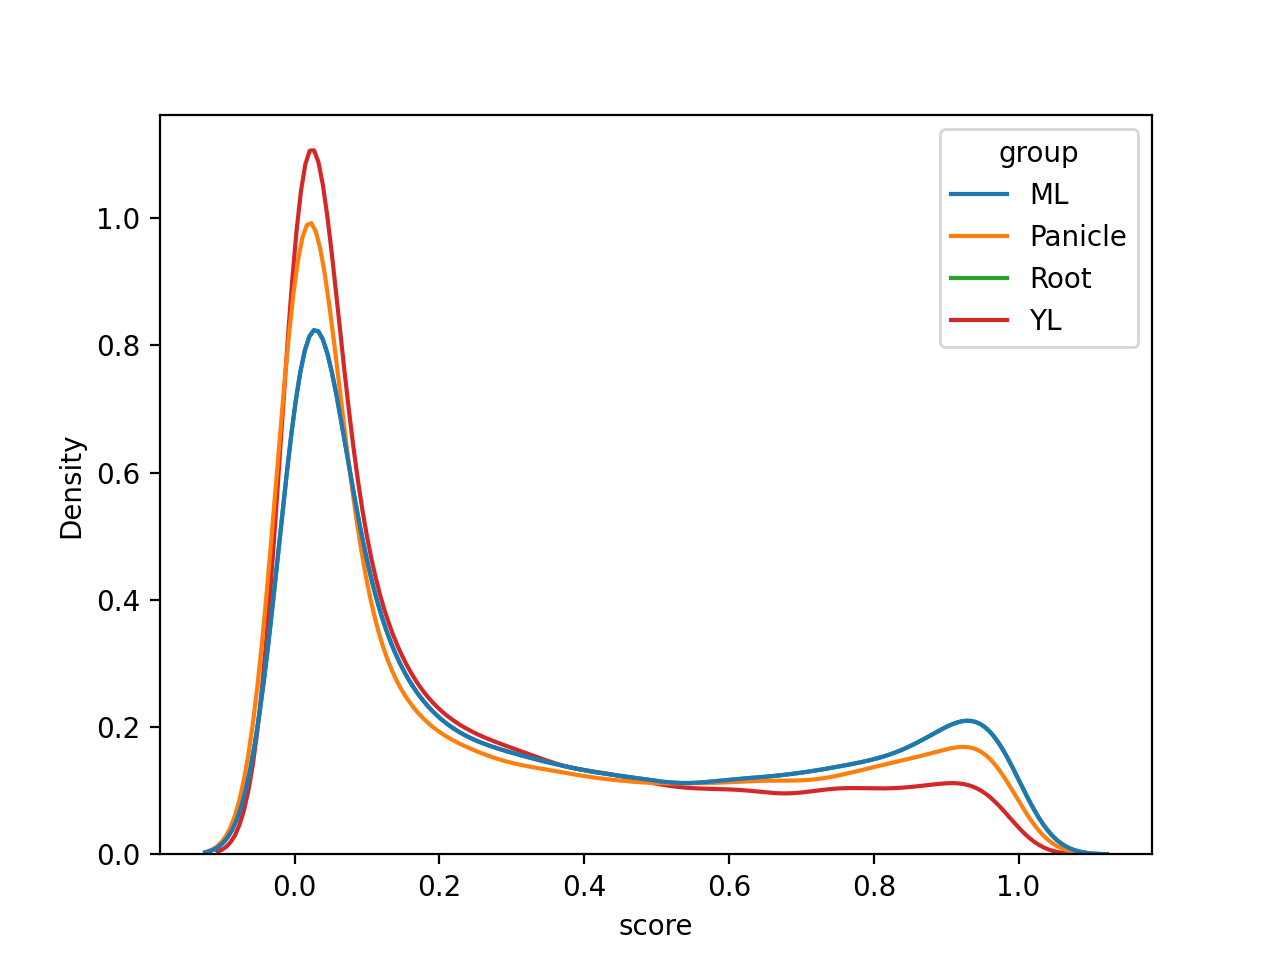

In [114]:
test = pd.read_table("score/mature_leaf_H3K4me3_predicted_score_predict_distal_ATAC")
test['group'] = "ML"
test1 = pd.read_table("score/panicle_H3K4me3_predicted_score_predict_distal_ATAC")
test1['group'] = "Panicle"
test2 = pd.read_table("score/mature_leaf_H3K4me3_predicted_score_predict_distal_ATAC")
test2['group'] = "Root"
test3 = pd.read_table("score/young_leaf_H3K4me3_predicted_score_predict_distal_ATAC")
test3['group'] = "YL"
# test4 = pd.read_table("score/mature_leaf_H3K4me3_predicted_score_NIP_TSS_random_1kb.tsv")
# test4['group'] = "random"
# test5 = pd.read_table("score/root_H3K4me3_predicted_score_untraning_test11.tsv")
# test5['group'] = "train"
# test6 = pd.read_table("score/root_H3K4me3_predicted_score_untraning_test22.tsv")
# test6['group'] = "test"
# test7 = pd.read_table("score/all_tissues_atac_training_predicted_score_ATAC.tsv")
# test7['group'] = "ATAC"
import seaborn as sns
import matplotlib.pyplot as plt
all = pd.concat([test, test1, test2, test3])
sns.kdeplot(data=all, x="score", hue="group")
plt.show()

In [115]:
all

,sequence,score,group
0,1:40491-41491,0.000000,ML
1,1:101904-102904,0.009694,ML
2,1:102796-103796,0.233325,ML
3,1:103536-104536,0.018028,ML
4,1:105578-106578,0.448195,ML
...,...,...,...
35705,Un:54790-55790,0.492346,YL
35706,Un:179089-180089,0.532421,YL
35707,Un:255937-256937,0.011057,YL
35708,Un:299438-300438,0.063570,YL


In [33]:
res = open("./result/possible_H3K4me3.tsv","w")
for i in possible_seqs_ind:
    res.write(pre_ids[i]+"\n")
res.close()

In [24]:
len(pre_ids)

29572

In [31]:
len(possible_seqs_ind)

7785

In [117]:
#atac = pd.read_table("./score/mature_leaf_H3K4me3_predicted_score_predict_distal_ATAC").rename(columns={"score":"ATAC"})
ml = pd.read_table("./score/mature_leaf_H3K4me3_predicted_score_predict_distal_ATAC").rename(columns={"score":"ML"})
panicle = pd.read_table("./score/panicle_H3K4me3_predicted_score_predict_distal_ATAC",usecols=[1]).rename(columns={"score":"Panilce"})
yl = pd.read_table("./score/young_leaf_H3K4me3_predicted_score_predict_distal_ATAC",usecols=[1]).rename(columns={"score":"YL"})
root = pd.read_table("./score/root_H3K4me3_predicted_score_predict_distal_ATAC",usecols=[1]).rename(columns={"score":"Root"})
res = pd.concat([ml, panicle, yl, root],axis=1)
#res['score'] = res['ATAC'] + res['ML_H3K4me3'] + res['Panilce_H3K4me3'] + res['YL_H3K4me3'] + res['Root_H3K4me3']
res

,sequence,ML,Panilce,YL,Root
0,1:40491-41491,0.000000,0.000000,0.000000,0.000000
1,1:101904-102904,0.009694,0.019928,0.019645,0.039196
2,1:102796-103796,0.233325,0.126742,0.578302,0.509743
3,1:103536-104536,0.018028,0.037588,0.029557,0.006720
4,1:105578-106578,0.448195,0.217768,0.101231,0.100073
...,...,...,...,...,...
35705,Un:54790-55790,0.895526,0.448285,0.492346,0.073869
35706,Un:179089-180089,0.676994,0.825076,0.532421,0.579120
35707,Un:255937-256937,0.265669,0.002957,0.011057,0.004884
35708,Un:299438-300438,0.049756,0.294698,0.063570,0.114636


In [76]:
res[res['score'] >= 2.5]

,sequence,ATAC,ML_H3K4me3,Panilce_H3K4me3,YL_H3K4me3,Root_H3K4me3,score
1,1:26621-27621,0.473233,0.547895,0.812705,0.741613,0.698823,3.274270
5,1:65993-66993,0.618049,0.887454,0.940605,0.876718,0.956819,4.279645
8,1:102805-103805,0.605038,0.486054,0.470222,0.318617,0.661166,2.541097
21,1:181685-182685,0.302688,0.497897,0.726608,0.828837,0.559869,2.915899
23,1:189925-190925,0.907204,0.917064,0.948861,0.701763,0.837180,4.312072
...,...,...,...,...,...,...,...
29560,Un:154195-155195,0.434313,0.886968,0.686425,0.787598,0.919328,3.714632
29564,Un:295412-296412,0.786453,0.892204,0.876242,0.825452,0.914079,4.294430
29565,Un:299446-300446,0.685161,0.924478,0.958690,0.889128,0.429577,3.887034
29569,Un:554700-555700,0.877322,0.538615,0.324753,0.135999,0.641017,2.517706


In [58]:
ml.shape

(29572, 2)